# Build a Multi-Omics Container for GCN Training
The goal of this little notebook is to create one HDF5 container that contains a feature matrix consisting of our multi-omics data:
* Mutation Frequencies
* Gene Expression
* Methylation

We then can train our network using the iref PPI and these different data sources.

In [57]:
import h5py, sys, os
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn
import networkx as nx
import mygene

sys.path.append(os.path.abspath('../../GCN'))
import gcnPreprocessing
plt.rc('font', family='Times New Roman')
%matplotlib inline

## Parameters

In [2]:
# PARAMETERS
use_quantile_norm = False # quantile or MinMax normalization
use_ncg_labels = True # use the new labels or the old ones
use_gefc = True # use fold changes of gene expression instead of FPKM read counts
#ppi_network = 'CPDB'

## Functions

In [58]:
def get_gene_symbols(list_of_ensembl_ids):
    # get Ensembl IDs for gene names
    mg = mygene.MyGeneInfo()
    res = mg.querymany(list_of_ensembl_ids,
                       scopes='ensembl.gene',
                       fields='symbol',
                       species='human', returnall=True
                      )

    def get_symbol_and_ensembl(d):
        if 'symbol' in d:
            return [d['query'], d['symbol']]
        else:
            return [d['query'], None]

    node_names = [get_symbol_and_ensembl(d) for d in res['out']]
    # now, retrieve the names and IDs from a dictionary and put in DF
    #print ("{} gene names (symbols) mapped successfully".format(len(ens_ids)))
    node_names = pd.DataFrame(node_names, columns=['Ensembl_ID', 'Symbol']).set_index('Ensembl_ID')
    node_names.dropna(axis=0, inplace=True)
    return node_names

## Load the data from disk and unify

In [128]:
# Load mutation data
mutations = pd.read_csv('../../data/pancancer/TCGA/mutation/mutation_frequencies_mean.tsv', sep='\t')
mutations.set_index('Name', inplace=True)
mutations.columns = ['Ensembl_ID'] + mutations.columns[1:].tolist()

# Load methylation
methylation = pd.read_csv('../../data/pancancer/TCGA/methylation/methylation_means_fc.tsv', sep='\t')
methylation.columns = ['Name'] + [i.upper() for i in methylation.columns[1:]]
methylation.set_index('Name', inplace=True)

# Load expression
expression = pd.read_csv('../../data/pancancer/TCGA/expression/expression_gtexnormfc_mean.tsv', sep='\t')
expression.columns = ['Name'] + [i.upper() for i in expression.columns[1:]]
expression.set_index('Name', inplace=True)

# Load PPI network
ppi_network = pd.read_csv('../../data/networks/CPDB_ens_edgelist.tsv', sep='\t')
ppi_graph = nx.from_pandas_edgelist(df=ppi_network, source='partner1', target='partner2', edge_attr='confidence')
ppi_network = nx.to_pandas_adjacency(G=ppi_graph)

# Next, I have to remove cancer types only present in a subset of the data
relevant_ctypes = list(set(mutations.columns[1:]).intersection(*[set(expression.columns), set(methylation.columns)]))
mutations = mutations[relevant_ctypes]
methylation = methylation[relevant_ctypes]
expression = expression[relevant_ctypes]

# Next, get the symbols for the network nodes
symbols_network_genes = get_gene_symbols(ppi_network.index)

# Remove nodes from network that don't have corresponding gene names
nodes_not_translatable = ppi_network[~ppi_network.index.isin(symbols_network_genes.index)].index
ppi_graph.remove_nodes_from(nodes_not_translatable)
ppi_network = nx.to_pandas_adjacency(G=ppi_graph)
assert ((ppi_network.index == symbols_network_genes.index).all())

# Finally, reindex to the network nodes such that everything is in the same order and non-network genes are removed
mutations_ppiindex = mutations.reindex(symbols_network_genes.Symbol, fill_value=0)
methylation_ppiindex = methylation.reindex(symbols_network_genes.Symbol, fill_value=0)
expression_ppiindex = expression.reindex(symbols_network_genes.Symbol, fill_value=0)

# print some stats
mut_nodes = mutations[mutations.index.isin(symbols_network_genes.Symbol)].shape[0]
meth_nodes = methylation[methylation.index.isin(symbols_network_genes.Symbol)].shape[0]
ge_nodes = expression[expression.index.isin(symbols_network_genes.Symbol)].shape[0]
print ("Network has {} nodes/genes".format(ppi_network.shape[0]))
print ("* {} genes in network have mutations".format(mut_nodes))
print ("* {}  genes in network have methylation data".format(meth_nodes))
print ("* {} genes in network have gene expression".format(ge_nodes))

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-13542...done.
Finished.
2 input query terms found no hit:
	['ENSG00000116957', 'ENSG00000284413']
Network has 13540 nodes/genes
* 12139 genes in network have mutations
* 9348  genes in network have methylation data
* 9447 genes in network have gene expression


In [129]:
# verify that the genes are the same and that they are in the same order
print ((mutations_ppiindex.index == methylation_ppiindex.index).all())
print ((mutations_ppiindex.index == expression_ppiindex.index).all())
print ((methylation_ppiindex.index == expression_ppiindex.index).all())
print ((mutations_ppiindex.index == symbols_network_genes.Symbol).all())
print ((ppi_network.index == symbols_network_genes.index).all())

True
True
True
True
True


## Join Multi-Omics to form one feature matrix

In [130]:
if use_quantile_norm:
    scaler = preprocessing.QuantileTransformer(output_distribution='normal')
    ge_norm = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(scaler.fit_transform(expression_ppiindex))
    #mutfreq_norm = scaler.fit_transform(mutfreq_features)
    mutfreq_norm = preprocessing.MinMaxScaler().fit_transform(mutations_ppiindex)
    meth_norm = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit_transform(methylation_ppiindex)
else:
    scaler = preprocessing.MinMaxScaler()
    ge_norm = scaler.fit_transform(np.abs(expression_ppiindex))
    mutfreq_norm = scaler.fit_transform(mutations_ppiindex)
    meth_norm = scaler.fit_transform(np.abs(methylation_ppiindex))

multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)
multi_omics_features_raw = np.concatenate((mutations_ppiindex, methylation_ppiindex, expression_ppiindex), axis=1)

In [131]:
np.save('../../data/pancancer/multiomics_features_raw_{}.npy'.format('fc' if use_gefc else 'fpkm'), multi_omics_features_raw)

### Plot Distribution of Features

In [132]:
expression_ppiindex.shape, mutations_ppiindex.shape, methylation_ppiindex.shape, ppi_network.shape, symbols_network_genes.shape

((13540, 16), (13540, 16), (13540, 16), (13540, 13540), (13540, 1))

"\nif use_quantile_norm:\n    fig.savefig('multi_omics_feature_distribution_quantiled.png', dpi=300)\nelse:\n    fig.savefig('multi_omics_feature_distribution_normminmax.png', dpi=300)\n"

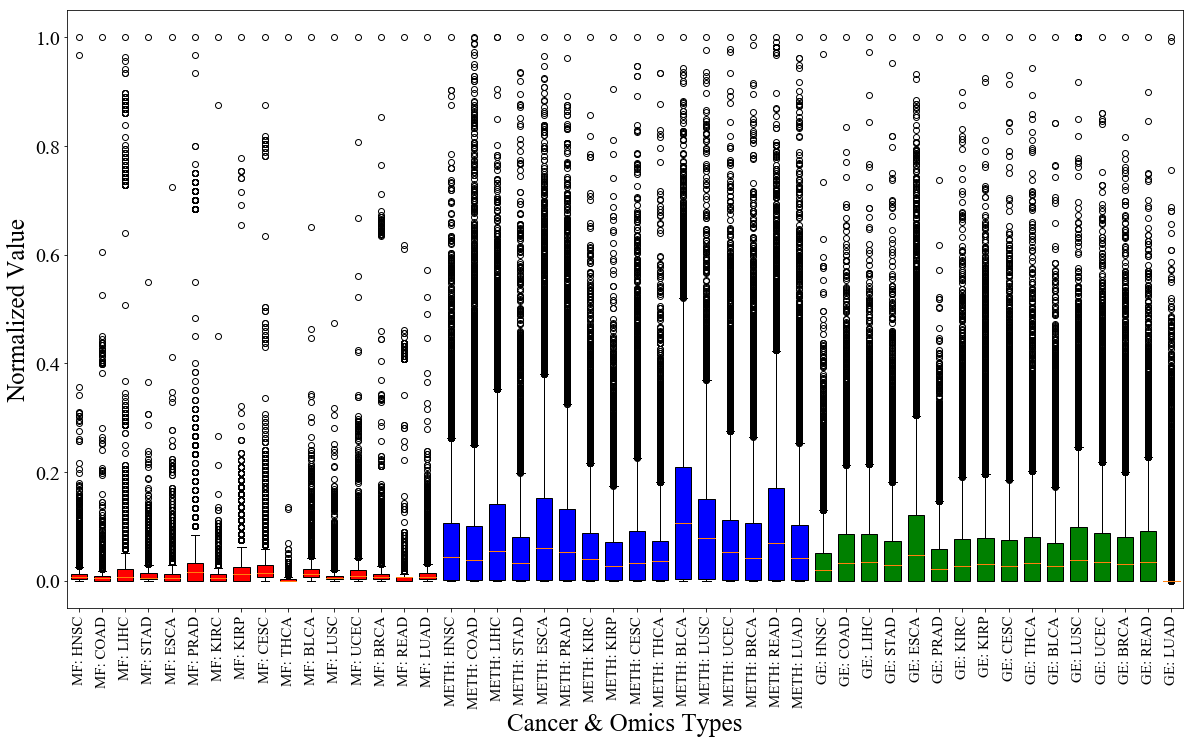

In [133]:
# plot distribution of features
fig = plt.figure(figsize=(20, 11))

# mutation frequencies
feat_names_mut = ['MF: ' + i.upper() for i in mutations_ppiindex.columns]

# gene expression
feat_names_ge = ['GE: ' + i.upper() for i in expression_ppiindex.columns]

# methylation
feat_names_meth = ['METH: ' + i.upper() for i in methylation_ppiindex.columns]
feat_names_all = feat_names_mut + feat_names_meth + feat_names_ge

# plot
x = plt.boxplot(multi_omics_features, widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, multi_omics_features.shape[1]+1), feat_names_all, rotation='vertical', fontsize=15)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

# fill with colors
colors = ['red']*len(feat_names_mut) + ['blue']*len(feat_names_meth) + ['green']*len(feat_names_ge)
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

#plt.gca().set_ylim([-2, 2])
plt.xlabel('Cancer & Omics Types', fontsize=25)
plt.ylabel('Normalized Value', fontsize=25)
#plt.title('Distribution of Multi-Omics Data', fontsize=30)
"""
if use_quantile_norm:
    fig.savefig('multi_omics_feature_distribution_quantiled.png', dpi=300)
else:
    fig.savefig('multi_omics_feature_distribution_normminmax.png', dpi=300)
"""

Text(0, 0.5, 'Abs. Foldchange')

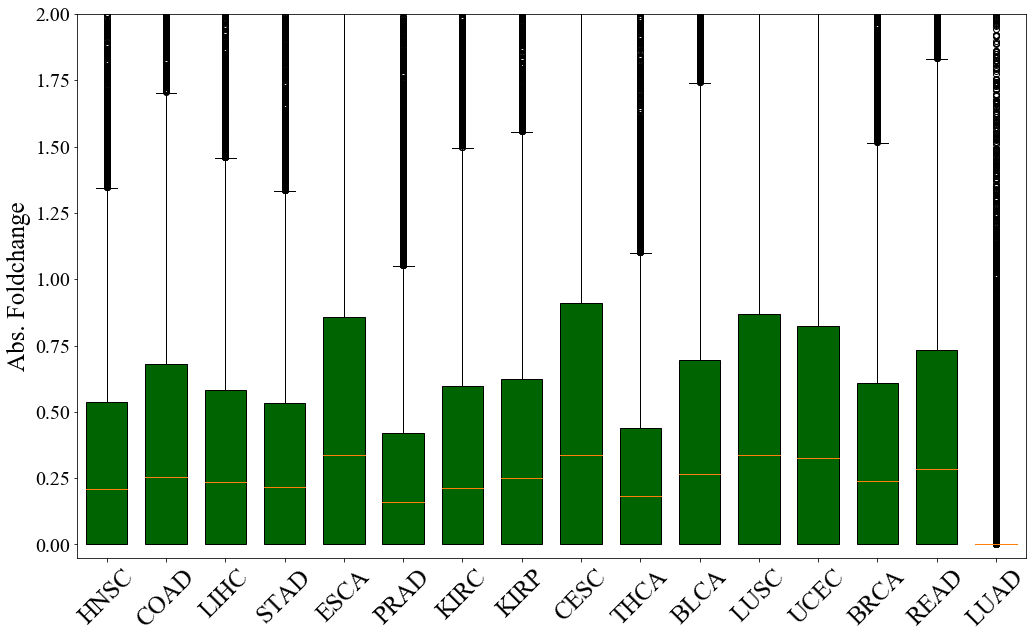

In [134]:
fig = plt.figure(figsize=(17, 10))

# plot
x = plt.boxplot(np.abs(expression_ppiindex.values), widths=0.7, patch_artist=True)
_ = plt.xticks(range(1, expression_ppiindex.shape[1]+1), [i.upper() for i in expression_ppiindex.columns], rotation=45, fontsize=25)
_ = plt.setp(plt.gca().get_yticklabels(), fontsize=20)

colors = ['darkgreen']*len(feat_names_ge)
for patch, color in zip(x['boxes'], colors):
    patch.set_facecolor(color)

plt.gca().set_ylim([-0.05, 2])
#plt.gca().set_ylim([-0.05, 1])
#plt.gca().set_ylim([-0.005, 0.05])
plt.xlabel('', fontsize=25)
#plt.ylabel('Frequency', fontsize=25)
plt.ylabel('Abs. Foldchange', fontsize=25)
#plt.title('Distribution of Multi-Omics Data', fontsize=30)
#fig.savefig('../../plots/input_ge.png', dpi=300)

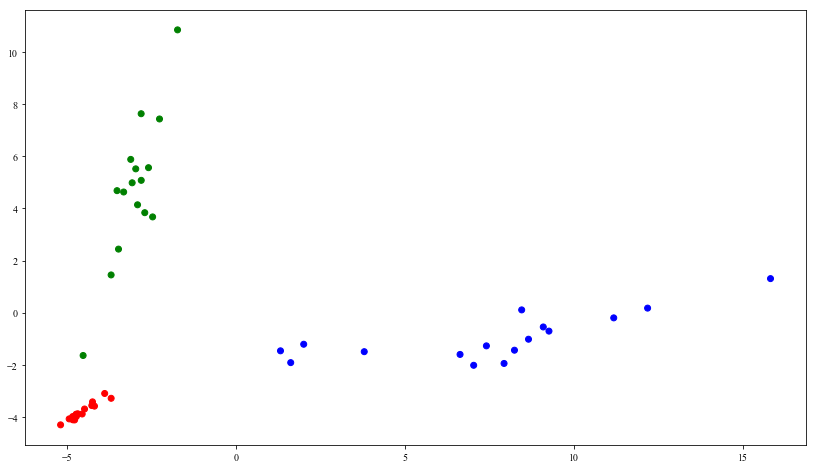

In [135]:
from sklearn.decomposition import PCA

emb = PCA(n_components=2).fit_transform(multi_omics_features.T)
fig = plt.figure(figsize=(14, 8))
plt.scatter(x=emb[:, 0], y=emb[:, 1], c=['red']*len(feat_names_mut)+['blue']*len(feat_names_meth)+['green']*len(feat_names_ge))

## Get Labels

In [136]:
symbols_network_genes.columns = ['Name']
nodes = symbols_network_genes

known_cancer_genes = []
candidate_cancer_genes = []
n = 0
with open('../../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
    for line in f.readlines():
        n += 1
        if n == 1:
            continue
        l = line.strip().split('\t')
        if len(l) == 2:
            known_cancer_genes.append(l[0])
            candidate_cancer_genes.append(l[1])
        else:
            candidate_cancer_genes.append(l[0])

known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name
known_cancer_genes_innet.shape, len(known_cancer_genes)

((705,), 711)

In [137]:
print ("{} genes are in network".format(nodes.shape[0]))

# get rid of the positives (known cancer genes)
not_positives = nodes[~nodes.Name.isin(known_cancer_genes)]
print ("{} genes are in network but not in positives (known cancer genes from NCG)".format(not_positives.shape[0]))

# get rid of OMIM genes associated with cancer
omim_cancer_genes = pd.read_csv('../../data/pancancer/OMIM/genemap_search_cancer.txt',
                                sep='\t', comment='#', header=0, skiprows=3)
# use fact that nan != nan for filtering out NaN
sublists = [sublist for sublist in omim_cancer_genes['Gene/Locus'].str.split(',') if sublist == sublist]
omim_cancer_geneset = [item.strip() for sublist in sublists for item in sublist]
not_omim_not_pos = not_positives[~not_positives.Name.isin(omim_cancer_geneset)]
print ("{} genes are also not in OMIM cancer genes".format(not_omim_not_pos.shape[0]))

# remove COSMIC cancer gene census genes
cosmic_gene_scores = pd.read_csv('../../data/pancancer/cosmic/cancer_gene_census.csv', header=0)
not_omim_cosmic_pos = not_omim_not_pos[~not_omim_not_pos.Name.isin(cosmic_gene_scores['Gene Symbol'])]
print ("{} genes are also not in COSMIC cancer gene census".format(not_omim_cosmic_pos.shape[0]))

# remove COSMIC highly mutated genes
cosmic_prcoding_mutations = pd.read_csv('../../data/pancancer/cosmic/CosmicMutantExportCensus.tsv.gz',
                                        compression='gzip', sep='\t')
non_pos_omim_cosmiccgc_cosmic_mutated = not_omim_cosmic_pos[~not_omim_cosmic_pos.Name.isin(cosmic_prcoding_mutations['Gene name'])]
print ("{} genes are also not in COSMIC mutated genes".format(non_pos_omim_cosmiccgc_cosmic_mutated.shape[0]))

# remove genes that belong to KEGG pathways in cancer
kegg_cancer_pathway_genes = pd.read_csv('../../data/pancancer/KEGG/KEGG_genes_in_pathways_in_cancer.txt',
                                        skiprows=2, header=None, names=['Name'])
not_pos_omim_cosmic_kegg = non_pos_omim_cosmiccgc_cosmic_mutated[~non_pos_omim_cosmiccgc_cosmic_mutated.Name.isin(kegg_cancer_pathway_genes.Name)]
print ("{} genes are also not in KEGG cancer pathways".format(not_pos_omim_cosmic_kegg.shape[0]))

# get rid of genes that are not candidate cancer genes
negatives = not_pos_omim_cosmic_kegg[~not_pos_omim_cosmic_kegg.Name.isin(candidate_cancer_genes)]
print ("{} genes are also not in NCG candidate cancer genes".format(negatives.shape[0]))

# collect genes in KEGG cancer modules
kegg_cancer_module_genes = []
count = 0
with open('../../data/pancancer/KEGG/KEGG_cancer_modules.gmt', 'r') as f:
    for line in f:
        for item in line.split('\t')[2:]:
            kegg_cancer_module_genes.append(item.strip())
kegg_cancer_module_genes = list(set(kegg_cancer_module_genes))

# collect genes in KEGG cancer gene neighborhoods
kegg_cancer_neighborhood_genes = []
count = 0
with open('../../data/pancancer/KEGG/KEGG_cancer_neighborhoods.gmt', 'r') as f:
    for line in f:
        for item in line.split('\t')[2:]:
            kegg_cancer_neighborhood_genes.append(item.strip())
kegg_cancer_neighborhood_genes = list(set(kegg_cancer_neighborhood_genes))

negatives = negatives[~negatives.Name.isin(kegg_cancer_module_genes) & ~negatives.Name.isin(kegg_cancer_neighborhood_genes)]
print ("{} genes also not in KEGG cancer modules or KEGG cancer gene neighborhoods".format(negatives.shape[0]))

13540 genes are in network
12835 genes are in network but not in positives (known cancer genes from NCG)
12812 genes are also not in OMIM cancer genes
12808 genes are also not in COSMIC cancer gene census
12806 genes are also not in COSMIC mutated genes
12604 genes are also not in KEGG cancer pathways
11384 genes are also not in NCG candidate cancer genes
4381 genes also not in KEGG cancer modules or KEGG cancer gene neighborhoods


## Do Training and Test Split

In [138]:
if use_ncg_labels:
    y = nodes.Name.isin(known_cancer_genes_innet).values.reshape(-1, 1)
    mask = nodes.Name.isin(negatives.Name) | nodes.Name.isin(known_cancer_genes_innet)
else:
    y = np.logical_or(y_train, y_test)
    mask = np.logical_or(train_mask, test_mask)

In [139]:
y_train, train_mask, y_test, test_mask = gcnPreprocessing.train_test_split(y, mask, 0.25)
y_train, train_mask, y_val, val_mask = gcnPreprocessing.train_test_split(y_train, train_mask, 0.1)
y_train.shape, train_mask.shape, y_test.shape, test_mask.shape, y_val.shape, val_mask.shape

((13540, 1), (13540,), (13540, 1), (13540,), (13540, 1), (13540,))

## Write back everything to container

In [140]:
def write_hdf5_container(fname, adj, F, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask, feature_names, features_raw):
    f = h5py.File(fname, 'w')
    string_dt = h5py.special_dtype(vlen=str)
    f.create_dataset('network', data=adj, shape=adj.shape)
    f.create_dataset('features', data=F, shape=F.shape)
    f.create_dataset('gene_names', data=node_names, dtype=string_dt)
    f.create_dataset('y_train', data=y_train, shape=y_train.shape)
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)
    f.create_dataset('y_test', data=y_test, shape=y_test.shape)
    f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
    f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
    f.create_dataset('feature_names', data=np.array(feature_names, dtype=object), dtype=string_dt)
    f.create_dataset('features_raw', data=features_raw, shape=features_raw.shape)
    f.close()

    print ("Container written to {}".format(fname))

In [141]:
multi_omics_features = np.concatenate((mutfreq_norm, meth_norm, ge_norm), axis=1)
fname = '../../data/pancancer/CPDB_multiomics.h5'
write_hdf5_container(fname, ppi_network.values, multi_omics_features, nodes, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_all, multi_omics_features_raw)

Container written to ../../data/pancancer/CPDB_multiomics.h5


## Compute Containers for combinations of two omics data

In [18]:
meth_ge_features = np.concatenate((meth_norm, ge_norm), axis=1)
fname = '../../data/pancancer/iref_methge_{}_{}.h5'.format('qnorm' if use_quantile_norm else 'norm',
                                                           'ncglabels' if use_ncg_labels else 'vogellabels')
write_hdf5_container(fname, network,meth_ge_features, node_names, y_train, y_val, y_test,
                     train_mask, val_mask, test_mask, feat_names_meth + feat_names_ge,
                     np.concatenate((meth_features, ge_features), axis=1))

Container written to ../../data/pancancer/iref_methge_norm_ncglabels.h5


In [19]:
meth_mutfreq_features = np.concatenate((meth_norm, mutfreq_norm), axis=1)
fname = '../../data/pancancer/iref_methmutfreq_{}_{}.h5'.format('qnorm' if use_quantile_norm else 'norm',
                                                                'ncglabels' if use_ncg_labels else 'vogellabels')
write_hdf5_container(fname, network, meth_mutfreq_features, node_names, y_train, y_val,
                     y_test, train_mask, val_mask, test_mask, feat_names_meth + feat_names_mut,
                     np.concatenate((meth_features, mutfreq_features), axis=1))

Container written to ../../data/pancancer/iref_methmutfreq_norm_ncglabels.h5


In [20]:
mutfreq_ge_features = np.concatenate((mutfreq_norm, ge_norm), axis=1)
fname = '../../data/pancancer/iref_mutfreqge_{}_{}.h5'.format('qnorm' if use_quantile_norm else 'norm',
                                                              'ncglabels' if use_ncg_labels else 'vogellabels')
write_hdf5_container(fname, network,
                     mutfreq_ge_features, node_names, y_train, y_val, y_test, train_mask, val_mask, test_mask,
                     feat_names_mut + feat_names_ge, np.concatenate((mutfreq_features, ge_features), axis=1))

Container written to ../../data/pancancer/iref_mutfreqge_norm_ncglabels.h5


## Write out single omics combinations

In [22]:
fname = '../../data/pancancer/iref_mutfreq_ncglabels.h5'
write_hdf5_container(fname, network, mutfreq_norm, node_names, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_mut, mutfreq_features)

Container written to ../../data/pancancer/iref_mutfreq_ncglabels.h5


In [23]:
fname = '../../data/pancancer/iref_newmeth_ncglabels.h5'
write_hdf5_container(fname, network, meth_norm, node_names, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_meth, meth_features)

Container written to ../../data/pancancer/iref_newmeth_ncglabels.h5


In [24]:
fname = '../../data/pancancer/iref_datadesc_gefc_ncglabels.h5'
write_hdf5_container(fname, network, ge_norm, node_names, y_train,
                     y_val, y_test, train_mask, val_mask, test_mask, feat_names_ge, ge_features)

Container written to ../../data/pancancer/iref_datadesc_gefc_ncglabels.h5
